In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import (
    ConcreteModel, Var, Objective, Constraint, NonNegativeReals, Binary, SolverFactory, RangeSet, Set
)

In [2]:
# Number of clients
n = 20
# Read input data of clients, filter on number of clients
data = pd.read_csv('data/clients.csv', sep=';')
clients = data.iloc[:n]

In [3]:
# Depot index and its coordinates
depot, dep_x, dep_y = 0, 150, 150
# Extract data
xc = [dep_x] + data['xcord'].tolist()
yc = [dep_y] + data['ycord'].tolist()
demand = data['demand'].tolist()

In [4]:
# Problem setup
# Set of clients
N = [i for i in range(1, n+1)]
# Set of vertices
V = [depot] + N
# Set of arcs, {(i,j) in V^2 : i != j}
A = [(i,j) for i in V for j in V if i != j]
# Distance metric, euclidean
def distance(i,j):
    return float(np.hypot(xc[i] - xc[j], yc[i] - yc[j]))

# Cost of travelling between nodes
c = {(i,j): distance(i,j) for i,j in A}
# Capacity of agents
Q = 10
# Demand per client
q = {i: demand[i-1] for i in N}

Minimum number of agents to fulfill all demand: 5.0 -> 5


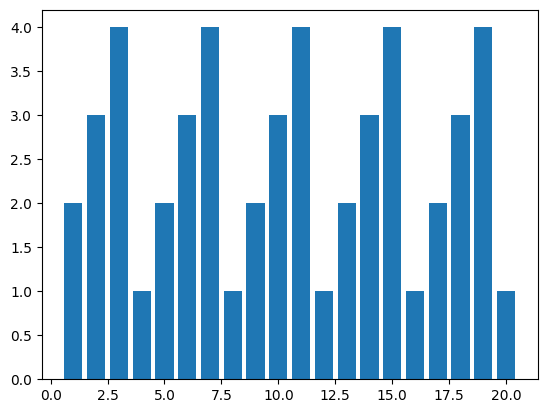

In [5]:
clients = np.array(list(q.keys()))
demand = np.array(list(q.values()))
plt.bar(clients, demand)
b = sum(list(q.values())) / Q
nr_of_vehicles = int(np.ceil(b))
print('Minimum number of agents to fulfill all demand:', b, '->', nr_of_vehicles)


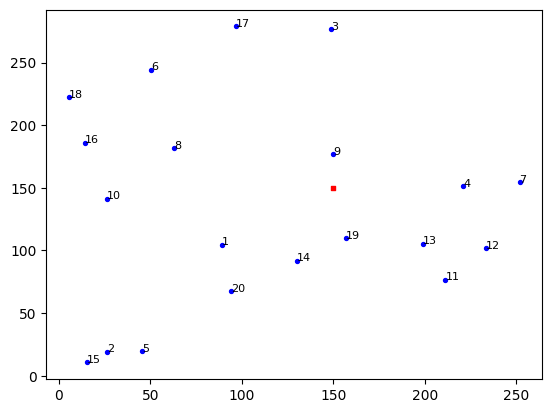

In [6]:
# Visualization of map
plt.figure()
size = 8
# Plot home depot with red
plt.scatter(xc[depot], yc[depot], c='r', marker='s', s=size)
# Plot clients locations with blue markers
for i in N:
    plt.scatter(xc[i], yc[i], c='b', s=size)
    plt.text(xc[i], yc[i], str(i), fontsize=8)


In [7]:
# Define the problem
model = ConcreteModel()

# Sets
model.N = Set(initialize=N) # Nodes
model.V = Set(initialize=V) # All vertices, including depot
model.A = Set(initialize=A) # Arcs

# Parameters
model.q = {i: q[i] for i in N} # Customer demand
model.c = {key: c[key] for key in A} # Costs
model.Q = Q # Vehicle capacity


In [8]:
# Decision variables
model.x = Var(model.A, domain=Binary) # Binary decision variables for route selection
model.f = Var(model.A, domain=NonNegativeReals) # Flow variables
model.u = Var(model.N, domain=NonNegativeReals, bounds=(0, len(N))) # Node visitation order

In [9]:
# Objective function: Minimize total cost
def objective_function(m):
    return sum(m.x[i,j] * m.c[i,j] for i,j in m.A)

model.objective = Objective(rule=objective_function, sense=1)

In [10]:
# Constraints
# Each node must be entered exactly once
def node_enter_rule(m, i):
    return sum(m.x[i, j] for j in m.V if j != i) == 1

model.NodeEnter = Constraint(model.N, rule=node_enter_rule)

# Each node must be exited exactly once
def node_exit_rule(m, j):
    return sum(m.x[i, j] for i in m.V if i != j) == 1

model.NodeExit = Constraint(model.N, rule=node_exit_rule)

# Subtour elimination (MTZ formulation)
def subtour_elimination_rule(m, i, j):
    if i != 0 and j != 0:
        return m.u[i] - m.u[j] + len(m.N) * m.x[i,j] <= len(m.N) - 1
    return Constraint.Skip

model.SubTourElimination = Constraint(model.A, rule=subtour_elimination_rule)

# Customer demand constraint
def customer_demand_rule(m, i):
    return m.u[i] >= model.q[i]

model.CustomerDemand = Constraint(model.N, rule=customer_demand_rule)

# Vehicle flow constraints
def vehicle_flow_balance_rule(m, i):
    return sum(m.f[j,i] for j in m.V if j != i) - sum(m.f[i,j] for j in m.V if j != i) == m.q[i]

model.VehicleFlowBalance = Constraint(model.N, rule=vehicle_flow_balance_rule)

# Flow lower bound
def flow_lower_bound_rule(m, i, j):
    return m.f[i,j] >= 0

model.FlowLowerBound = Constraint(model.A, rule=flow_lower_bound_rule)

# Flow upper bound
def flow_upper_bound_rule(m, i, j):
    return m.f[i,j] <= m.Q * m.x[i,j]

model.FlowUpperBound = Constraint(model.A, rule=flow_upper_bound_rule)



In [11]:
# Solve the model
solver_path = "C:\\Users\\eriks\\Dev\\CBC\\Cbc-releases.2.10.12-w64-msvc16-md\\bin\\cbc.exe"
solver = SolverFactory('cbc', executable=solver_path)
solver.options['seconds'] = 600
result = solver.solve(model, tee=True)

Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Aug 20 2024 

command line - C:\Users\eriks\Dev\CBC\Cbc-releases.2.10.12-w64-msvc16-md\bin\cbc.exe -seconds 600 -printingOptions all -import C:\Users\eriks\AppData\Local\Temp\tmp3vak924j.pyomo.lp -stat=1 -solve -solu C:\Users\eriks\AppData\Local\Temp\tmp3vak924j.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 600
Option for printingOptions changed from normal to all
Presolve 860 (-440) rows, 860 (0) columns and 3580 (-440) elements
Statistics for presolved model
Original problem has 420 integers (420 of which binary)
==== 440 zero objective 211 different
==== absolute objective values 211 different
==== for integers 0 zero objective 210 different
==== for integers absolute objective values 210 different
===== end objective counts


Problem has 860 rows, 860 columns (420 with objective) and 3580 elements
Column breakdown:
420 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
20 of type lo->up, 0 of t

In [12]:
# Print results
print("Status:", result.solver.status)
print("Termination status:", result.solver.termination_condition)
active_arcs = []
for (i,j) in model.A:
    if model.x[i,j].value > 0.5:
        # print('Route from {} to {} is used.'.format(i,j))
        active_arcs.append((i,j))
print('Objective value:', model.objective())


Status: ok
Termination status: optimal
Objective value: 1703.6228720550203


In [13]:
starting_nodes = [(i,j) for i,j in active_arcs if i == 0]
print('Nr of routes:', len(starting_nodes))

print('Paths')
paths = []
for node in starting_nodes:
    at_start = False
    path = []
    while not at_start:
        path.append(node)
        current, target = node
        node = [(i,j) for i,j in active_arcs if i == target][0]
        if target == 0:
            at_start = True
    
    paths.append(path)
    print(path)

Nr of routes: 6
Paths
[(0, 1), (1, 10), (10, 16), (16, 18), (18, 8), (8, 0)]
[(0, 4), (4, 7), (7, 12), (12, 11), (11, 0)]
[(0, 6), (6, 17), (17, 3), (3, 0)]
[(0, 9), (9, 0)]
[(0, 14), (14, 19), (19, 13), (13, 0)]
[(0, 20), (20, 5), (5, 15), (15, 2), (2, 0)]


Text(0.5, 1.0, 'Total cost: 1703.62')

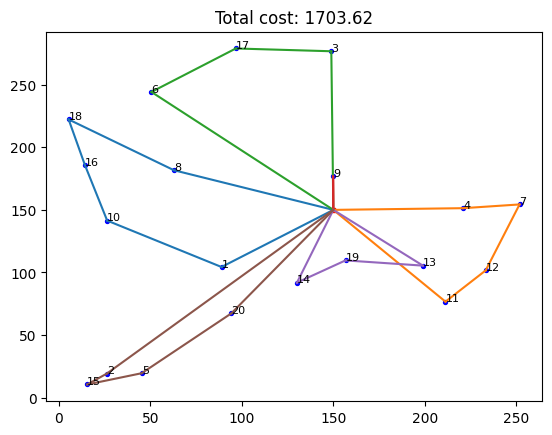

In [14]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# Visualization of map
plt.figure()
size = 8
# Plot home depot with red
plt.scatter(xc[depot], yc[depot], c='r', marker='s', s=size)
# Plot clients locations with blue markers
for i in N:
    plt.scatter(xc[i], yc[i], c='b', s=size)
    plt.text(xc[i], yc[i], str(i), fontsize=8)
for k, path in enumerate(paths):
    for i,j in path:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c=colors[k%len(colors)])

plt.title('Total cost: {}'.format(round(model.objective(), 2)))